In [5]:
# conda package imports
import os,sys
import numpy as np
import logging
import scipy.ndimage
from matplotlib import pyplot as plt
import pandas
import math
from scipy import interpolate
import copy
pandas.options.display.max_columns = None

# Watershed Workflow
import workflow
import workflow.ui
import workflow.densify_rivers_hucs
import workflow.source_list
import workflow.split_hucs
import workflow.daymet

### Importing river network and HUC

In [6]:
name = 'Portage1' # name the domain, used in filenames, etc
hucs = ['041000090101',] # a list of HUCs to run
simplify = 30 # length scale to target average edge
ignore_small_rivers = 30 # ignore rivers which have this or fewer reaches.  likely they are irrigation ditches
                       # or other small features which make things complicated but likely don't add much value
prune_by_area_fraction = 0.03 # ignore reaches whose accumulated catchment area is less than this fraction of the
                             # full domain's area
start_year = 1980  # year to start simulation
log_to_file = False  # if true, write to file instead of in the notebook output
rivers = True

# parameter checking
assert(simplify > 0 and simplify < 300)
assert(ignore_small_rivers == None or (ignore_small_rivers >= 0 and ignore_small_rivers <= 100))
assert(prune_by_area_fraction == None or (prune_by_area_fraction >= 0 and prune_by_area_fraction < 1))
assert(start_year >= 1980 and start_year < 2020)

if log_to_file:
    outputs['logfile'] = f'{name}.log'
    # is this right?  the file handle will become stale... test once this is pipelined.
    with open(outputs['logfile'], 'w') as fid:
        workflow.ui.setup_logging(1,fid)
else:
    workflow.ui.setup_logging(1,None)
 
logging.info("")
logging.info(f"Meshing shape: {hucs}")
logging.info("="*30)

# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = workflow.crs.daymet_crs()

# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
sources['DEM'] = workflow.source_list.dem_sources['NED 1/3 arc-second']
workflow.source_list.log_sources(sources)

# load the huc
my_hucs = []
for huc in hucs:
    _, ws = workflow.get_huc(sources['HUC'], huc, crs)
    my_hucs.append(ws)

watershed = workflow.split_hucs.SplitHUCs(my_hucs)
watershed_=copy.deepcopy(watershed) # keeping the original

if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs, crs, include_catchments=True)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers_original = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=0.01, 
                                         snap=True, cut_intersections=False,
                                         ignore_small_rivers=ignore_small_rivers,
                                         prune_by_area_fraction=0.03)


    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, 
                                         snap=True, cut_intersections=False,
                                         ignore_small_rivers=ignore_small_rivers,
                                         prune_by_area_fraction=0.03)

else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)


2021-10-11 17:09:48,767 - root - INFO: 
2021-10-11 17:09:48,768 - root - INFO: Meshing shape: ['041000090101']
2021-10-11 17:09:48,768 - root - INFO: ==============================
2021-10-11 17:09:48,770 - root - INFO: Using sources:
2021-10-11 17:09:48,771 - root - INFO: --------------
2021-10-11 17:09:48,771 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-10-11 17:09:48,772 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-10-11 17:09:48,772 - root - INFO: DEM: National Elevation Dataset (NED)
2021-10-11 17:09:48,773 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-10-11 17:09:48,773 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-10-11 17:09:48,774 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-10-11 17:09:48,774 - root - INFO: soil thickness: None
2021-10-11 17:09:48,775 - root - I

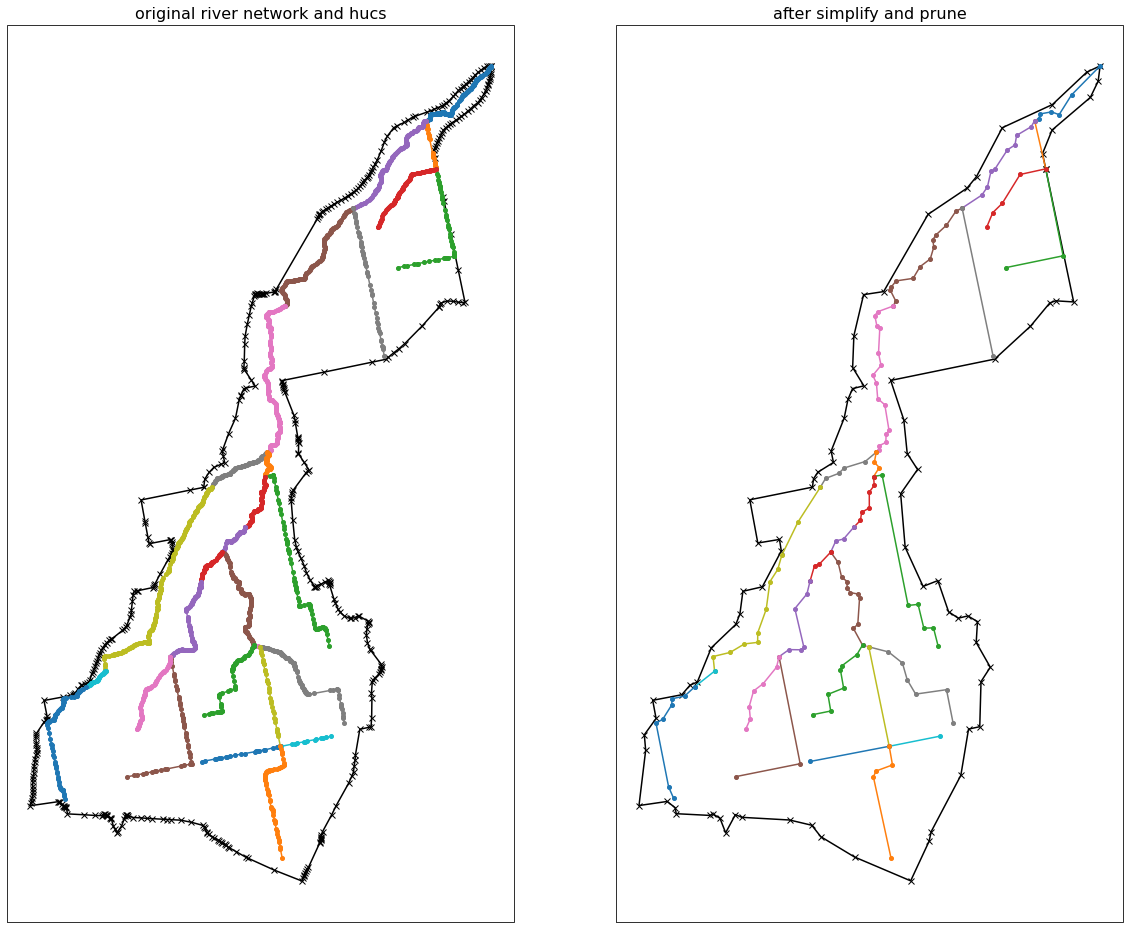

In [4]:
# Plotting original and simplified-pruned rivers adn watershed
river_=rivers_original[0]
river=rivers[0]

plt.rcParams['figure.figsize'] = [20, 20]

fig, axs = plt.subplots(1,2,subplot_kw={'projection':workflow.crs.to_cartopy(crs)})

axs[0].plot(watershed_.exterior().exterior.xy[0], watershed_.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
axs[1].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)

for node in river_.preOrder():
    x,y=node.segment.xy # node.segment gives us LS
    axs[0].plot(x,y,'-o',markersize=4)

for node in river.preOrder():
    x,y=node.segment.xy # node.segment gives us LS
    axs[1].plot(x,y,'-o',markersize=4)


### Densification of River Network and Watershed

In [8]:
#densify_watershed
watershed_densified=workflow.densify_rivers_hucs.DensifyHucs(watershed, watershed_, limit=300)

#densify_river
river_densified=workflow.densify_rivers_hucs.DensifyTree(river, river_, limit=200, collinear=True)

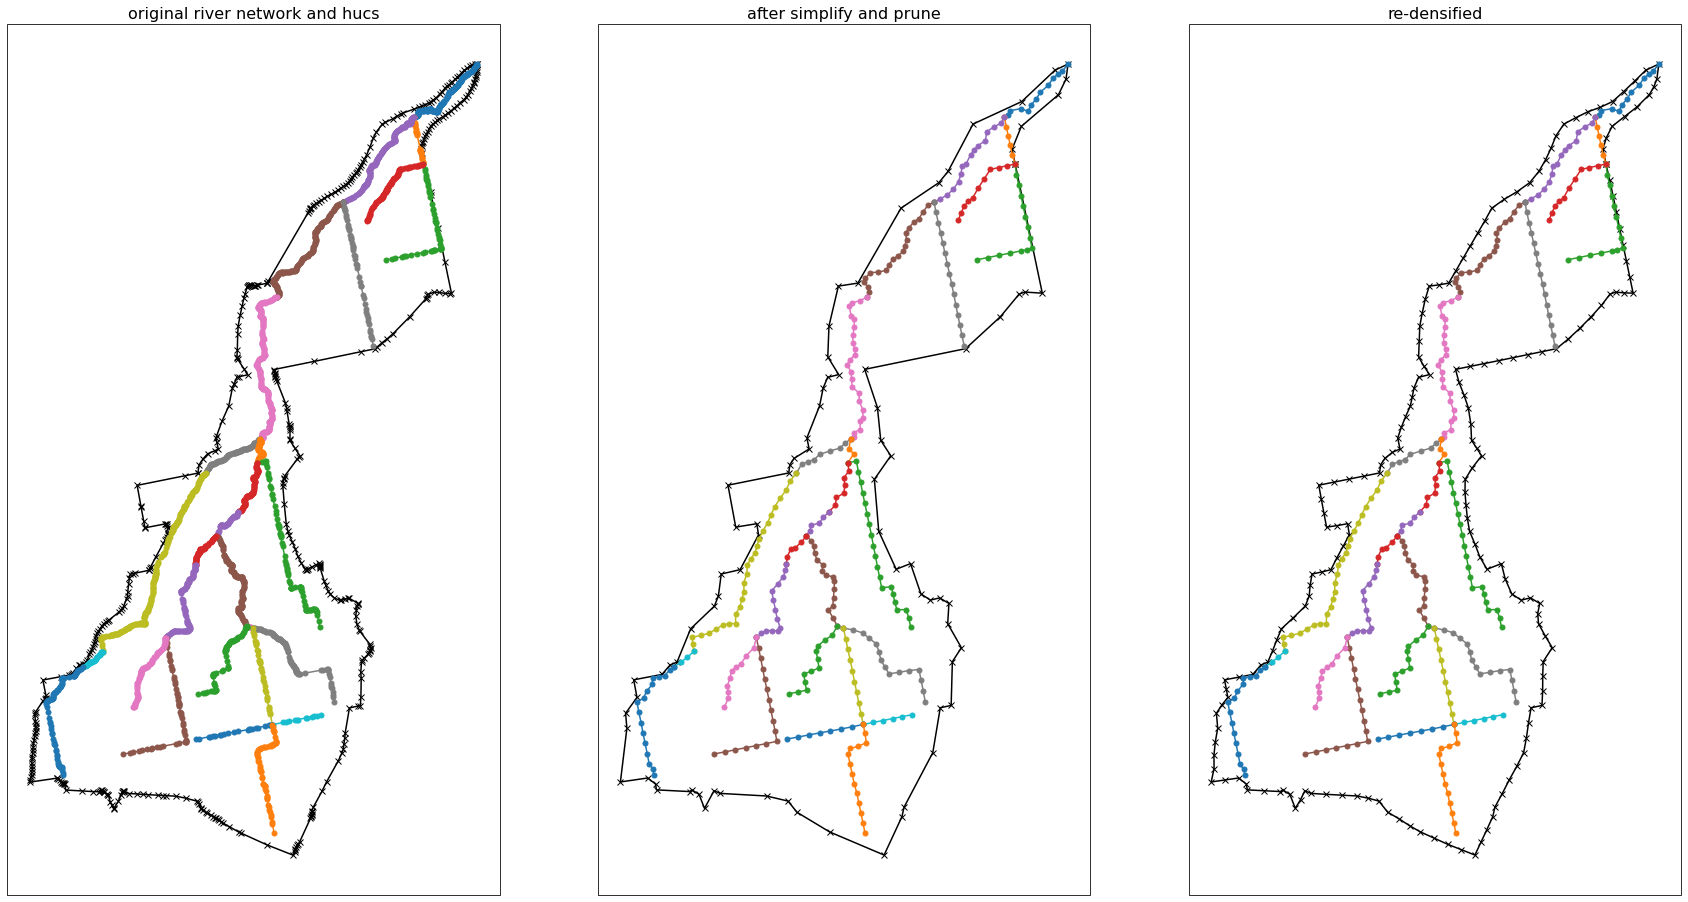

In [12]:
# plotting results
plt.rcParams['figure.figsize'] = [30, 20]

fig, axs = plt.subplots(1,3,subplot_kw={'projection':workflow.crs.to_cartopy(crs)})

axs[0].plot(watershed_.exterior().exterior.xy[0], watershed_.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
axs[1].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)
axs[2].plot(watershed_densified.exterior().exterior.xy[0], watershed_densified.exterior().exterior.xy[1], 'k-x')
axs[2].set_title('re-densified',fontsize=16)

for node in river_.preOrder():
    x,y=node.segment.xy # node.segment gives us LS
    axs[0].plot(x,y,'-o',markersize=5)

for node in river.preOrder():
    x,y=node.segment.xy # node.segment gives us LS
    axs[1].plot(x,y,'-o',markersize=5)

for node in river_densified.preOrder():
    x,y=node.segment.xy # node.segment gives us LS
    axs[2].plot(x,y,'-o',markersize=5)